In [4]:
%matplotlib inline

from __future__ import print_function

import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm


# Fit guassian to 1332 peak
from scipy.optimize import curve_fit

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def calc_fwhm(sigma):
    return 2 * np.sqrt(2 * np.log(2)) * sigma

def calc_resolution(height, sigma):
    return calc_fwhm(sigma) / height


/usr/local/lib/python2.7/dist-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


                            WLS Regression Results                            
Dep. Variable:                      x   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.438e+04
Date:                Thu, 14 Sep 2017   Prob (F-statistic):           1.35e-07
Time:                        15:28:40   Log-Likelihood:                -12.798
No. Observations:                   5   AIC:                             29.60
Df Residuals:                       3   BIC:                             28.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0333      3.865     -0.526      0.6

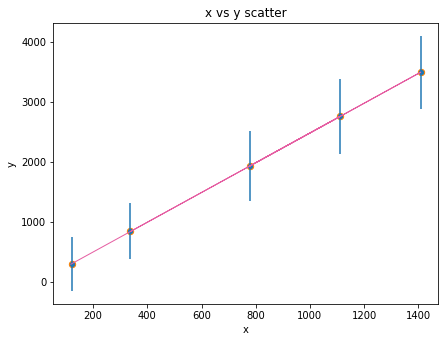

In [5]:
# Energies from Eu152 used for calibration
energy_list = [121.8, 1408, 778.9, 1112, 334.3,]
channel_list = [296.9, 3500, 1933, 2763, 850.9]
channel_err = np.array([4.470, 6.085, 5.795, 6.306, 4.654])

weights = 1/np.power(channel_err, 2)

# put x and y into a pandas DataFrame, and the weights into a Series
ws = pd.DataFrame({
    'x': energy_list,
    'y': channel_list,
    'yerr': map(lambda x: x * 100, channel_err)
})

wls_fit = sm.wls('x ~ y', data=ws, weights=1 / weights).fit()

# show the fit summary by calling wls_fit.summary()

print(wls_fit.summary())

# let's plot our data
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')
ws.plot(
    kind='scatter',
    x='x',
    y='y',
    yerr='yerr',
    style='o',
    alpha=1.,
    ax=ax,
    title='x vs y scatter',
    edgecolor='#ff8300',
    s=40
)

# weighted prediction
wp, = ax.plot(
    wls_fit.predict(),
    ws['y'],
    color='#e55ea2',
    lw=1.,
    alpha=1.0,
)

plt.tight_layout()
fig.set_size_inches(6.40, 5.12)
plt.savefig("so.png", dpi=100, alpha=True)
plt.show()

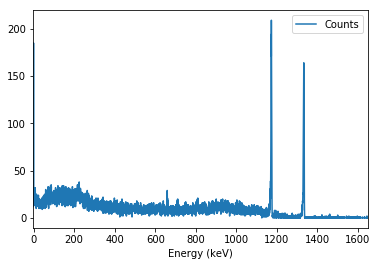

In [6]:
# Plot of Co60 counts vs Energy
plt.figure(1)
co60 = pd.read_csv("data/co60.csv", names=['Channel','Counts'], header=0)
co60['Energy (keV)'] = co60['Channel'].apply(lambda x: x*wls_fit.params['y'] + wls_fit.params['Intercept'])
co60.plot(x='Energy (keV)', y='Counts')
plt.show()

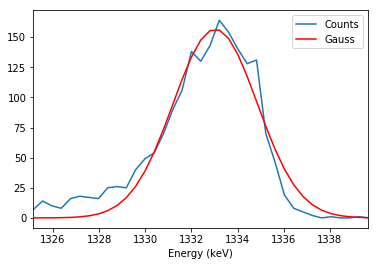

C60 1332 Fit
mean: 1333.03305361
sigma: -1.8234573875
Peak-to-Compton: 20.3045972441
Resolution: -0.0274207278389


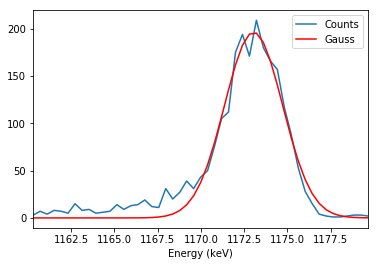

C60 1173 Fit
mean: 1173.04390744
sigma: -1.6794112608
Resolution: -0.0201424119269


In [7]:
# Get Compton range average for Co
co60_compton = co60.loc[(co60['Energy (keV)'] >= 1040) & (co60['Energy (keV)'] <=1096), ['Energy (keV)', 'Counts', 'Channel']]
compton_counts_mean = co60_compton.mean()['Counts']
#co60_compton

mean = 1332
std = 2


# Fit guassian to 1332 peak
co60_peak = co60.loc[(co60['Energy (keV)'] >= 1325) & (co60['Energy (keV)'] <=1340), ['Energy (keV)', 'Counts']]
popt1332, pcov = curve_fit(gauss_function, co60_peak['Energy (keV)'], co60_peak['Counts'], p0 = [1, mean, std])

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')
co60_peak.plot(x='Energy (keV)', y='Counts', ax=ax)
co60_peak['Gauss'] = co60_peak['Energy (keV)'].apply(lambda x: gauss_function(x, popt1332[0], popt1332[1], popt1332[2]))
co60_peak.plot(x='Energy (keV)', y='Gauss', ax=ax, color='red')
plt.show()

co60_1332_counts = gauss_function(popt1332[1], popt1332[0], popt1332[1], popt1332[2])
peak_to_compton = co60_1332_counts / compton_counts_mean
print("C60 1332 Fit")
print("mean:", popt1332[1])
print("sigma:", popt1332[2])
print("Peak-to-Compton:", peak_to_compton)
print("Resolution:", calc_resolution(co60_1332_counts, popt1332[2]))

# Fit guassian to 1173 peak
mean = 1173
std = 5
co60_low_peak = co60.loc[(co60['Energy (keV)'] >= 1160) & (co60['Energy (keV)'] <=1180), ['Energy (keV)', 'Counts']]
popt1173, pcov = curve_fit(gauss_function, co60_low_peak['Energy (keV)'], co60_low_peak['Counts'], p0 = [1, mean, std])

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')
co60_low_peak.plot(x='Energy (keV)', y='Counts', ax=ax)
co60_low_peak['Gauss'] = co60_low_peak['Energy (keV)'].apply(lambda x: gauss_function(x, popt1173[0], popt1173[1], popt1173[2]))
co60_low_peak.plot(x='Energy (keV)', y='Gauss', ax=ax, color='red')
plt.show()

print("C60 1173 Fit")
print("mean:", popt1173[1])
print("sigma:", popt1173[2])
co60_1173_counts = gauss_function(popt1173[1], popt1173[0], popt1173[1], popt1173[2])
print("Resolution:", calc_resolution(co60_1173_counts, popt1173[2]))


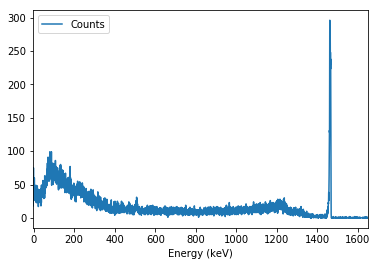

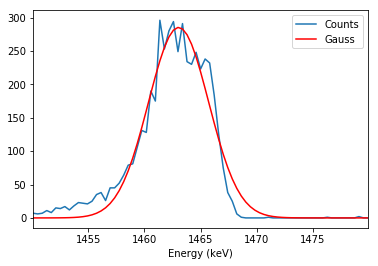

K40 Fit
mean: 1463.0419593
sigma: 2.68492328533
Resolution: 0.0221605748244
Peak/Background 29.5101611244


In [9]:
'''K40 resolution'''
plt.figure(1)
k40 = pd.read_csv("data/k40.csv", names=['Channel','Counts'], header=0)
k40['Energy (keV)'] = k40['Channel'].apply(lambda x: x*wls_fit.params['y'] + wls_fit.params['Intercept'])
k40.plot(x='Energy (keV)', y='Counts')
plt.show()

# Fit guassian to  peak
mean = 1450
std = 5
k40_peak = k40.loc[(k40['Energy (keV)'] >= 1450) & (k40['Energy (keV)'] <=1480), ['Energy (keV)', 'Counts']]
popt, pcov = curve_fit(gauss_function, k40_peak['Energy (keV)'], k40_peak['Counts'], p0 = [1, mean, std])

k40_background = k40.loc[(k40['Energy (keV)'] >= 600) & (k40['Energy (keV)'] <=800), ['Energy (keV)', 'Counts', 'Channel']]
background_mean = k40_background.mean()['Counts']

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')
k40_peak.plot(x='Energy (keV)', y='Counts', ax=ax)
k40_peak['Gauss'] = k40_peak['Energy (keV)'].apply(lambda x: gauss_function(x, popt[0], popt[1], popt[2]))
k40_peak.plot(x='Energy (keV)', y='Gauss', ax=ax, color='red')
plt.show()

print("K40 Fit")
print("mean:", popt[1])
print("sigma:", popt[2])
height_at_centroid = gauss_function(popt[1], popt[0], popt[1], popt[2])
print("Resolution:", calc_resolution(height_at_centroid, popt[2]))
print("Peak/Background", height_at_centroid/background_mean)



In [ ]:
def energy_error(channel, slope_uncertainty = wls_fit.bse['y'], intercept_uncertainty = wls_fit.bse['Intercept']):
    slope_error = channel * slope_uncertainty
    error = math.sqrt((slope_error ** 2) + intercept_uncertainty **2)
    
    return error

In [ ]:
co60_compton_error = map(energy_error, co60_compton.Channel)
avg_co60_compton_error = np.mean(co60_compton_error)
print(avg_co60_compton_error)

In [ ]:
#wls_fit.params['Intercept']
print(wls_fit.bse['Intercept']) # standard error on wls
print(wls_fit.bse['y']) # standard error on wls